# Practice in python 3: extraction of features and classification

Vamos witheçair importando the bibliotecas necessary and cairregando/creating some images of example that usaremos to the longo desta practice.

Imagens e formas de exemplo prontas.


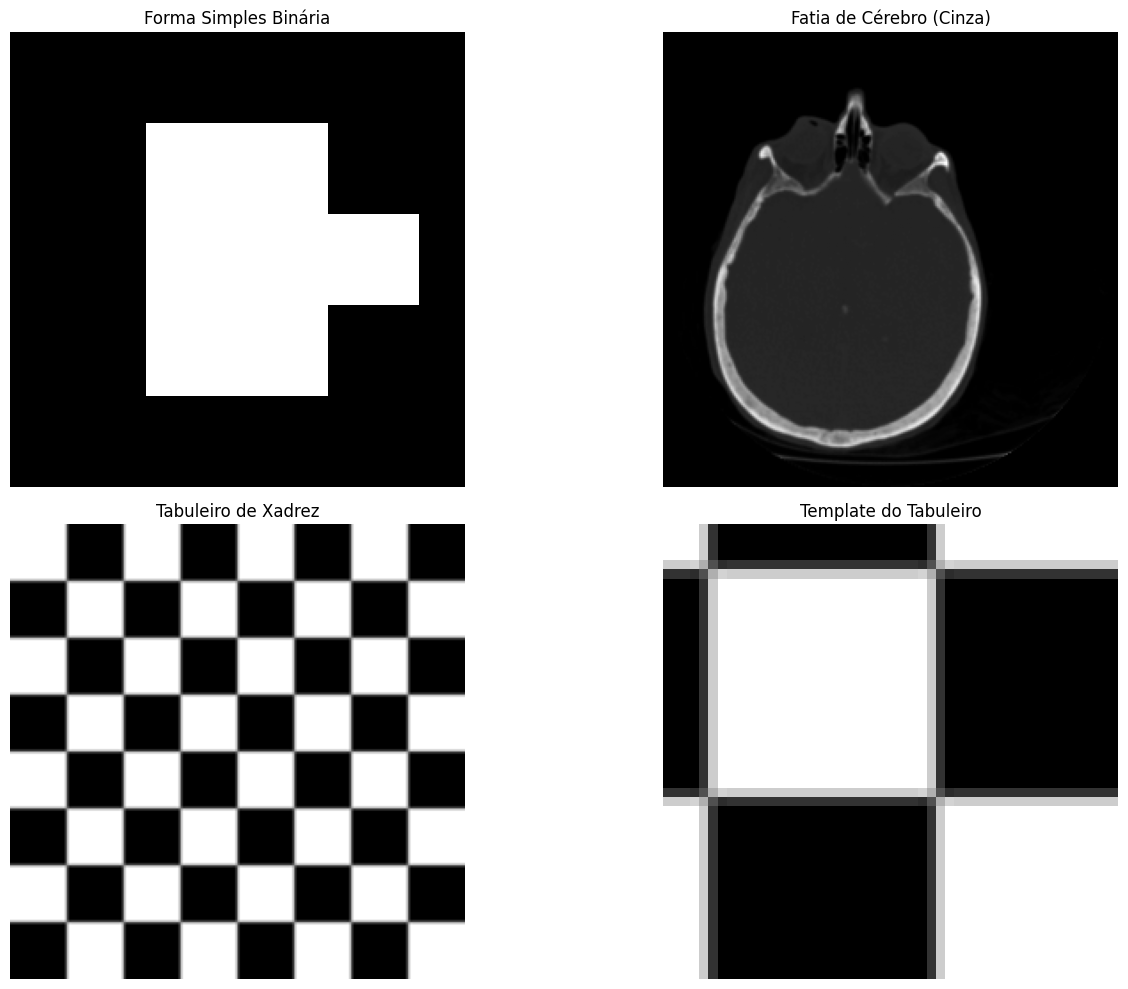

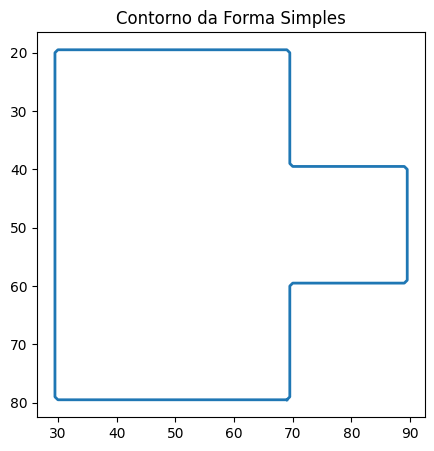

In [ ]:
# --- Importações necessary ---import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float, img_as_ubyte, io, measure, morphology, feature, transform, color, filters
from scipy import ndimage
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import cv2 # OpenCV for some operations as template matching and momentsimport os
from numpy.fft import fft, ifft, fft2, ifft2, fftshift, ifftshift

# --- Function Auxiliar of Plotagem ---def plot_many_images_c11_12(images, titles, rows=1, cols=None, cmaps=None, figsize=(15,10), main_title=None):
    num_images = len(images)
    if cols is None:
        cols = (num_images + rows - 1) // rows

    fig, axes = plt.subplots(rows, cols, figsize=figsize, squeeze=False)
    axes_flat = axes.ravel()

    if cmaps is None:
        cmaps_list = [None] * num_images
    elif isinstance(cmaps, str):
        cmaps_list = [cmaps] * num_images
    else:
        cmaps_list = list(cmaps)
        if len(cmaps_list) < num_images:
            last_cmap = cmaps_list[-1] if cmaps_list else None
            cmaps_list.extend([last_cmap] * (num_images - len(cmaps_list)))

    for i in range(len(axes_flat)):
        if i < num_images:
            img, title, cmap_val = images[i], titles[i], cmaps_list[i]
            axes_flat[i].imshow(img, cmap=cmap_val if img.ndim==2 or (img.ndim==3 and img.shape[-1]==1) else None)
            axes_flat[i].set_title(title)
            axes_flat[i].axis('off')
        else:
            axes_flat[i].axis('off')

    if main_title:
        fig.suptitle(main_title, fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 0.96] if main_title else None)
    plt.show()

# --- Criar/Carregar Imagens de Exemplo ---# Imagem para contornos e descritoressimple_shape = np.zeros((100, 100), dtype=np.uint8)
simple_shape[20:80, 30:70] = 1 # Retângulosimple_shape[40:60, 50:90] = 1 # Adiciona uma parte para forma em Lsimple_shape_labels = measure.label(simple_shape)
simple_shape_props = measure.regionprops(simple_shape_labels)
contour_coords = None
if simple_shape_props: # Pega o contorno do maior objeto    # Encontrar the larger objeto (case haja multiple desconectados)    largest_obj_idx = np.argmax([prop.area for prop in simple_shape_props])
    contour_coords = measure.find_contours(simple_shape_labels == (largest_obj_idx + 1), 0.5)[0]


# Image for textura and moments regionais (usaremos the of the cérebro)try:
    brain_volume = data.brain()
    if brain_volume.ndim == 3:
        slice_idx = brain_volume.shape[0] // 2
        brain_slice_c11 = brain_volume[slice_idx, :, :]
    elif brain_volume.ndim == 2:
        brain_slice_c11 = brain_volume
    else: # Fallback if data. Brain() not estiver as esperado        print("Formato inesperado para data.brain(), usando data.camera()")
        brain_slice_c11 = data.camera()
except Exception as e:
    print(f"Erro ao carregar data.brain(): {e}. Usando data.camera().")
    brain_slice_c11 = data.camera()
brain_slice_c11_ubyte = img_as_ubyte(brain_slice_c11)


# Imagem para template matchingchecker_c11 = data.checkerboard()
# Criar um template a partir da imagemtemplate_c11 = checker_c11[20:70, 20:70].copy() # Um template 50x50
print("Imagens e formas de exemplo prontas.")
plot_many_images_c11_12(
    [simple_shape, brain_slice_c11_ubyte, checker_c11, template_c11],
    ["Forma Simples Binária", "Fatia de Cérebro (Cinza)", "Tabuleiro de Xadrez", "Template do Tabuleiro"],
    2, 2, cmaps=['gray','gray','gray','gray']
)
if contour_coords is not None:
    plt.figure(figsize=(5,5))
    plt.plot(contour_coords[:, 1], contour_coords[:, 0], linewidth=2)
    plt.gca().invert_yaxis() # The axis y of the image is invertido    plt.title("Contorno da Forma Simples")
    plt.show()

### Interpretando the Results (Configuração Inicial): - This bloco should cairregair the bibliotecas and to create/cairregair the images of example sem erros. - Você verá: a form binary simples, a fatia of cérebro in tons of cinza, a tabuleiro of xadrez and a small template retirado of the tabuleiro. - The contour of the form simples also will be plotado, that usaremos for descritores of contour.

## Module 1: chapter 11 Focaremos in as to represent objetos (after the segmentation) and descrevê-los quantitativamente.

### 1.1. Representação: **Explanation Breve:** - Representação: after the segmentation, the objetos can to be representados by their features externas (contour) or internas (region). - Seguimento of Contour: Algoritmos for traçair the edge of a objeto in a image binary. - Códigos of String (Chain Codes): Represent a contour as a sequence of small segmentos direcionais of withprimento unit (using, for example, 4 or 8 directions). Is a representação withpacta and invairiant à translação. **As the Code Funciona (Chain Code Simples):** 1. Uses `contour_coords` of the form simples definida in the configuração. 2. Calculates the differences between coordenadas of pixels consecutivos in the contour. 3. Mapeia those differences for a code of string of 4 directions (0: direita, 1: cima, 2: esquerda, 3: baixo). (For simplificair, not implementaremos the normalização of the point inicial or rotação here).


--- Módulo 1.1: Códigos de Cadeia ---
Contorno (primeiros 5 pontos): 
[[80 69]
 [80 68]
 [80 67]
 [80 66]
 [80 65]]
Código de Cadeia de 4 direções (primeiros 20 passos): [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Comprimento do código de cadeia: 236


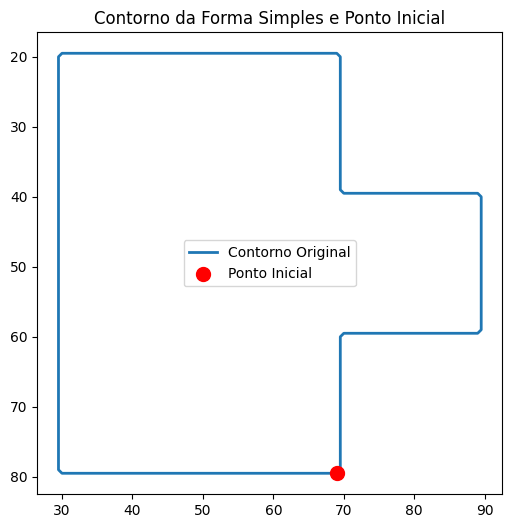

In [ ]:
# 1.1 Códigos of String (Chain Codes)print("\n--- Módulo 1.1: Códigos de Cadeia ---")

if contour_coords is not None and len(contour_coords) > 1:
    chain_code_4dir = []
    # The coordenadas of the contour are (line, coluna)    # (linha decresce = cima, linha cresce = baixo)    # (coluna decresce = esquerda, coluna cresce = direita)    # Ajuste para o sistema de coordenadas da imagem (y aumenta para baixo)    # 0: Direita (dx=1, dy=0) -> (0, 1) em (col, lin)    # 1: Cima (dx=0, dy=-1) -> (-1, 0) em (col, lin)    # 2: Esquerda (dx=-1, dy=0) -> (0, -1) em (col, lin)    # 3: Baixo (dx=0, dy=1) -> (1, 0) em (col, lin)
    # The coords of find_contours are (line, coluna)    # dy = diff_linha, dx = diff_coluna    # 0: Direita (d_col=1, d_lin=0)    # 1: Cima (d_col=0, d_lin=-1)    # 2: Esquerda (d_col=-1, d_lin=0)    # 3: Baixo (d_col=0, d_lin=1)
    for i in range(len(contour_coords) - 1):
        # diff = contour_coords[i+1] - contour_coords[i]        # Corrigindo para (linha, coluna)        # diff_row = contour_coords[i+1, 0] - contour_coords[i, 0]        # diff_col = contour_coords[i+1, 1] - contour_coords[i, 1]
        # For códigos of string, geralmente consideramos the vizinhos more next.        # Find_contours can retornar points not adjacentes in a grid.        # For a example simples, vamos assumir that the points are adjacentes        # Or vamos to calculate the direction predominante.        # A implementation robusta of chain code requer that the points of the contour sejam sequenciais and adjacentes in the grid.        # The `measure. Find_contours` retorna coordenadas float, that can not to be perfeitamente in the grid.        # For a example didático, vamos arredondar and to calculate the differences.
        pt_atual = np.round(contour_coords[i]).astype(int)
        pt_prox = np.round(contour_coords[i+1]).astype(int)

        diff_row = pt_prox[0] - pt_atual[0]
        diff_col = pt_prox[1] - pt_atual[1]

        code = -1 # Code inválido        if diff_col == 1 and diff_row == 0: code = 0 # Direita        elif diff_col == 0 and diff_row == -1: code = 1 # Cima        elif diff_col == -1 and diff_row == 0: code = 2 # Esquerda        elif diff_col == 0 and diff_row == 1: code = 3 # Baixo        # For 8-conectividade, adicionaríamos the diagonais
        if code != -1:
            chain_code_4dir.append(code)
        # Nota: If the points not forem estritamente adjacentes in the grid 4-conectada,        # This lógica simples can falhar or pular points.
    print(f"Contorno (primeiros 5 pontos): \n{np.round(contour_coords[:5]).astype(int)}")
    print(f"Código de Cadeia de 4 direções (primeiros 20 passos): {chain_code_4dir[:20]}")
    print(f"Comprimento do código de cadeia: {len(chain_code_4dir)}")

    # Visualizar o contorno original    plt.figure(figsize=(6,6))
    plt.plot(contour_coords[:, 1], contour_coords[:, 0], linewidth=2, label='Contorno Original')
    plt.scatter(contour_coords[0, 1], contour_coords[0, 0], c='red', s=100, label='Ponto Inicial', zorder=5)
    plt.gca().invert_yaxis()
    plt.title("Contorno da Forma Simples e Ponto Inicial")
    plt.legend()
    plt.show()
else:
    print("Contorno não encontrado para 'simple_shape'. Pule este exemplo.")

**Interpretando the Results (Códigos of String):** - Contour: The plot should to show the edge of the "Form Simples binary" with the point inicial maircado. - Code of String: The list of numbers impressa represents the sequence of directions (0-3) for traçair the contour the pairtir of the point inicial. This is the code of string. - Comprimento: The number of passos in the code of string, that if relaciona with the perímetro of the objeto. **Exercises:** 1. As você estenderia the code for to generate a code of string of 8 directions? Which seriam the new códigos and the condições for diff_row and diff_col?

## 1.2. Descritores of Contour **Explanation Breve:** after to obtain the contour, we can descrevê-lo using several medidas. - Descritores Simples: Comprimento of the perímetro, diâmetro, excentricidade. - Descritores of Fourier: Represent the contour in the domain of the frequency. The coordenadas (x, y) of the contour are tratadas as a signal withplex s(k)=x(k)+jy(k). The DFT of s(k) produz the descritores of Fourier. To use a subconjunto of the primeiros coefficients allows a approximation of the contour and is invairiant the some transformações. **As the Code Funciona** (Descritores of Fourier): 1. Uses `contour_coords` of the form simples. 2. Trata the coordenadas of the contour as a signal withplex: s(k)=coluna(k)+j⋅line(k). 3. Calculates the DFT 1D of s(k) using fft(). The result are the descritores of Fourier. 4. For reconstruir/aproximair the contour, uses-if a number limitado of the primeiros descritores (baixas frequencies, that capturam the form geral) and calculates-if the IDFT. 5. Visualiza the contour original and the reconstruído with different numbers of descritores.


--- Módulo 1.2: Descritores de Fourier ---


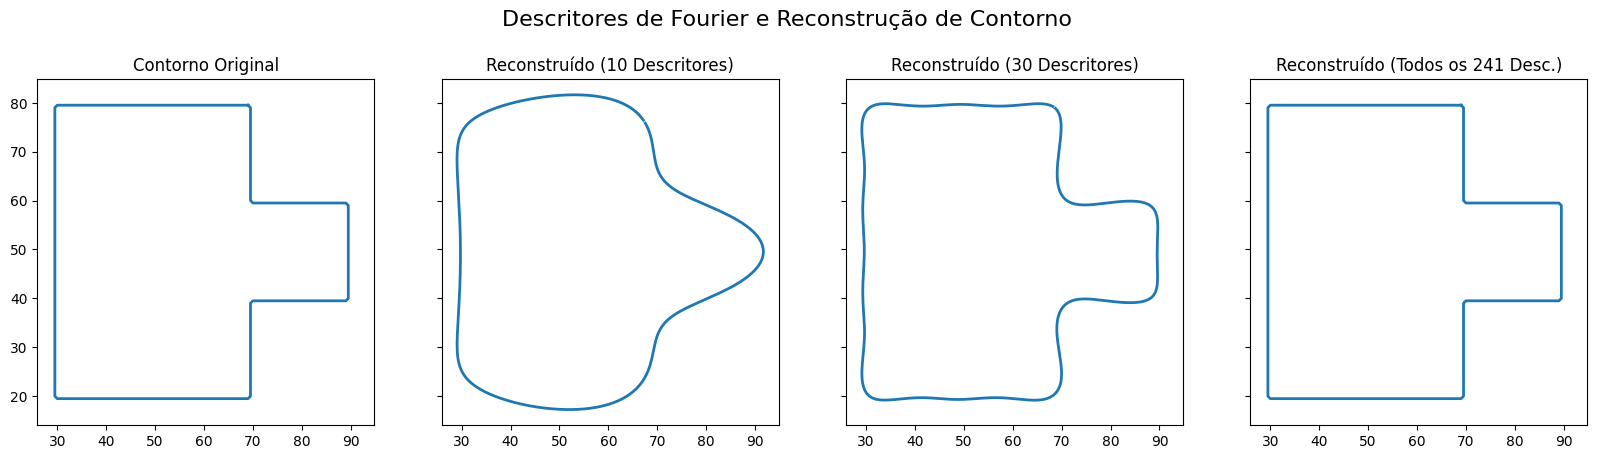

In [ ]:
# 1.2 Descritores de Contorno (Descritores de Fourier)print("\n--- Módulo 1.2: Descritores de Fourier ---")

if contour_coords is not None and len(contour_coords) > 1:
    # Tratar o contorno como um sinal complexo: s(k) = x(k) + j*y(k)    # Where x is the coordenada of the coluna and y is the coordenada of the line    # In the nosso contour_coords, contour_coords[:, 1] is coluna (x), contour_coords[:, 0] is line (y)    sinal_complexo_contorno = contour_coords[:, 1] + 1j * contour_coords[:, 0]

    # Calcular os Descritores de Fourier (DFT do sinal complexo)    descritores_fourier = fft(sinal_complexo_contorno)

    # Function for reconstruir the contour using a number N_desc of descritores    def reconstruir_contorno_fourier(descritores, N_desc, tamanho_original):
        if N_desc <= 0 or N_desc > len(descritores):
            N_desc = len(descritores) # To use all if N_desc for inválido
        # Manter the N_desc/2 primeiros and N_desc/2 últimos coefficients (baixas frequencies)        # If N_desc is ímpar, ajustar        desc_truncados = np.zeros_like(descritores, dtype=complex)

        # Manter component DC and the N_desc-1 frequencies more baixas (positivas and negativas)        # The spectrum of the DFT is tipicamente [DC, F_pos,..., F_Nyquist,..., F_neg]        # Para manter N_desc, pegamos DC, (N_desc-1)//2 positivas, e (N_desc-1)//2 negativas        # Se N_desc for par, N_desc/2 - 1 positivas, N_desc/2 negativas        # If N_desc for ímpar, (N_desc-1)/2 positivas, (N_desc-1)/2 negativas
        # A form more simples of truncar for N_desc components is        # Manter the primeiras N_desc/2 and the últimas N_desc/2 (after the DC).        # But for invariância à rotação and escala, processing more complex of the descritores is necessary.        # Here, vamos focar in the reconstruction of the form geral.        # For reconstruction visual, manter the frequencies more baixas is the more importante.        # The fftshift coloca the DC in the centro. Sem shift, DC is in [0].        # Baixas frequencies are near of the DC and in the extremidades of the array (devido à periodicidade).
        meio_n_desc = N_desc // 2
        if N_desc == 1: # Apenas DC             desc_truncados[0] = descritores[0]
        elif N_desc > 1 :
            desc_truncados[0] = descritores[0] # Manter DC            # Manter the primeiras (N_desc-1)//2 frequencies positivas            desc_truncados[1 : (N_desc -1)//2 + 1] = descritores[1 : (N_desc -1)//2 + 1]
            # Manter the últimas (N_desc-1)//2 frequencies negativas (simetria conjugada)            # If N_desc is par, N_desc/2 -1 positivas and N_desc/2 negativas            # Or more simples: manter the N_desc primeiros and if preocupar with simetria if for for invariância.            # For reconstruction simples:            desc_truncados[1:meio_n_desc+1] = descritores[1:meio_n_desc+1]
            if N_desc > 1: # Evitar índice negativo if N_desc=1                 desc_truncados[-meio_n_desc:] = descritores[-meio_n_desc:]


        contorno_reconst = ifft(desc_truncados)
        # Escalar of volta for the tamanho original if the IDFT not the fizer automaticamente        # (fft/ifft of the numpy preservam the "tamanho" in termos of number of points)        return np.column_stack((contorno_reconst.imag, contorno_reconst.real)) # (linha, coluna)
    # Reconstruir with different numbers of descritores    N_desc_10 = 10
    N_desc_30 = 30
    N_desc_todos = len(descritores_fourier)

    contorno_rec_10 = reconstruir_contorno_fourier(descritores_fourier, N_desc_10, len(sinal_complexo_contorno))
    contorno_rec_30 = reconstruir_contorno_fourier(descritores_fourier, N_desc_30, len(sinal_complexo_contorno))
    contorno_rec_todos = reconstruir_contorno_fourier(descritores_fourier, N_desc_todos, len(sinal_complexo_contorno))

    # Visualization    fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)
    fig.suptitle("Descritores de Fourier e Reconstrução de Contorno", fontsize=16)

    axs[0].plot(contour_coords[:, 1], contour_coords[:, 0], linewidth=2)
    axs[0].set_title('Contorno Original')

    axs[1].plot(contorno_rec_10[:, 1], contorno_rec_10[:, 0], linewidth=2)
    axs[1].set_title(f'Reconstruído ({N_desc_10} Descritores)')

    axs[2].plot(contorno_rec_30[:, 1], contorno_rec_30[:, 0], linewidth=2)
    axs[2].set_title(f'Reconstruído ({N_desc_30} Descritores)')

    axs[3].plot(contorno_rec_todos[:, 1], contorno_rec_todos[:, 0], linewidth=2)
    axs[3].set_title(f'Reconstruído (Todos os {N_desc_todos} Desc.)')

    for ax in axs:
        ax.invert_yaxis() # Ajustar orientação of the axis y        ax.set_aspect('equal', adjustable='box')
    plt.show()
else:
    print("Contorno não encontrado ou muito pequeno. Pule o exemplo de Descritores de Fourier.")

**Interpretando the Results (Descritores of Fourier):** * Contour Original: The form original. * Reconstruído (10 Descritores): Using only the primeiros 10 descritores of Fourier (that represent the withponents of frequency more baixas of the form of the contour), the reconstruction will be a versão suavizada and aproximada of the form original, capturando their features gerais, but perdendo detalhes finos. * Reconstruído (30 Descritores): With more descritores, the reconstruction will be more fiel à form original, incluindo more detalhes. * Reconstruído (All the Descritores): Deveria to be (quase) idêntica to the contour original. **Exercises** 1. Experimente with different values for `N_desc` in the function `reconstruir_contorno_fourier`. Which the smaller number of descritores that still fornece a representação visualmente recognizable of the form original? 2. The descritores of Fourier are invairiantes à translação. For torná-los invairiantes à escala and rotação, geralmente are processados (ex: using only the magnitudes of the descritores or normalizando the first descritor different of zero). Pesquise brevemente as the invairiância à rotação and escala can to be alcançada. (This is more conceitual).

## 1.3. Descritores Regionais **Explanation Breve:** Descrevem a region inteira (not only its contour). * Descritores Topológicos: Ex: Number of Euler (Number of objetos - Number of buracos). * Textura: Medidas of suavidade, rugosidade, regulairidade. Abordagens estatísticas (histograma, GLCM), estruturais, espectrais. Focaremos in some estatísticas simples. * Moments: Moments geometric and invairiantes (Hu moments) descrevem the form of the region and are invairiantes the translação, escala and rotação. **As the Code Funciona:** 1. Uses `brain_slice_c11_ubyte` and `simple_shape` (preenchida). 1. Number of Euler: `measure. Euler_number()`. 1. Textura (Estatísticas Simples): Calculates average, desvio pattern, suavidade (baseada in vairiância), uniformidade and entropia the pairtir of the histograma of a region of the image of the cérebro. 1. Moments of Hu: `cv2. Moments()` calculates moments espaciais. `cv2. HuMoments()` calculates the 7 moments of Hu the pairtir of the moments espaciais. These are aplicados à form simples preenchida.


--- Módulo 1.3: Descritores Regionais ---
Número de Euler para 'simple_shape' preenchida: 1

Descritores de Textura para região selecionada:
  Média: 26.63
  Desvio Padrão: 0.64
  Suavidade (R): 0.0000
  Uniformidade: 0.4223
  Entropia: 1.3605

Momentos de Hu (transformados por log):
  hu[1]: 3.1626
  hu[2]: 7.9175
  hu[3]: 7.9979
  hu[4]: 8.0000
  hu[5]: 8.0000
  hu[6]: -8.0000
  hu[7]: 8.0000


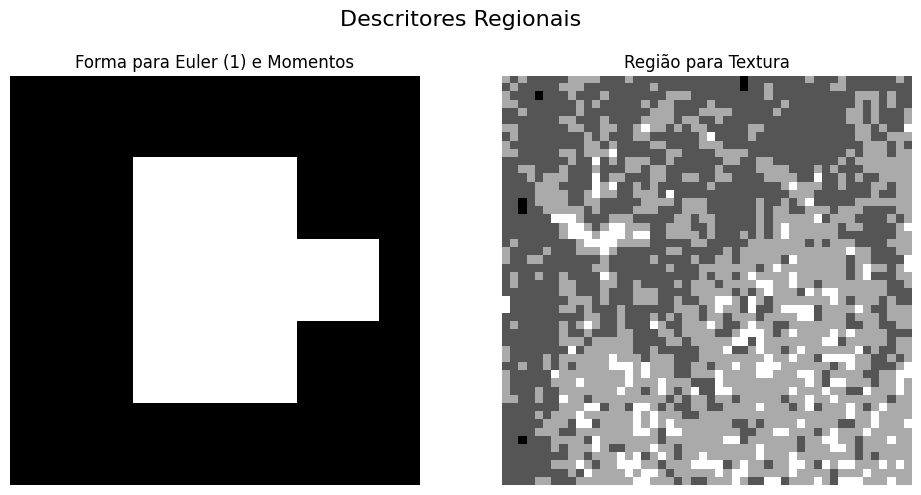

In [ ]:
from skimage.exposure import rescale_intensity, histogram

# 1.3 Descritores Regionaisprint("\n--- Módulo 1.3: Descritores Regionais ---")

if 'brain_slice_c11_ubyte' in globals() and 'simple_shape' in globals():
    # --- the) Descritores Topológicos (Number of Euler) ---    # For the Number of Euler, precisamos of a image binary and limpa.    # Usar a 'simple_shape' e garantir que esteja preenchida.    forma_preenchida_euler = ndimage.binary_fill_holes(simple_shape > 0)
    # Euler_number conta objetos - buracos. For a form sólida, should to be 1.    # For skimage < 0.19, connectivity is a argument. For >= 0.19, not is.    try:
        num_euler = measure.euler_number(forma_preenchida_euler, connectivity=2)
    except TypeError: # Versões more antigas can not to have connectivity or esperá-lo         try:
            num_euler = measure.euler_number(forma_preenchida_euler) # Tenta sem         except Exception as e_euler:
            print(f"Erro ao calcular número de Euler: {e_euler}")
            num_euler = "Erro"

    print(f"Número de Euler para 'simple_shape' preenchida: {num_euler}")

    # --- b) Textura (Descritores statistical Simples) ---    # Pegar a sub-region of the image of the cérebro for analysis of textura    # (ex: a region that pareça to have textura)    regiao_textura = brain_slice_c11_ubyte[100:150, 100:150]
    if regiao_textura.size == 0: # Fallback se o corte resultar em vazio        regiao_textura = brain_slice_c11_ubyte[0:50,0:50]

    if regiao_textura.size > 0:
        media_textura = np.mean(regiao_textura)
        std_textura = np.std(regiao_textura)
        # Suavidade (relacionada à variância) R = 1 - 1/(1+sigma^2)        # Normalizar std para [0,1] se a imagem estiver em [0,255]        std_norm_textura = std_textura / 255.0
        suavidade_textura = 1 - (1 / (1 + std_norm_textura**2))

        # Uniformidade e Entropia do Histograma        hist_textura, _ = histogram(regiao_textura, nbins=256, source_range='image')
        prob_textura = hist_textura / np.sum(hist_textura) # Normaliza para ser uma PDF        uniformidade_textura = np.sum(prob_textura**2)
        entropia_textura = -np.sum(prob_textura * np.log2(prob_textura + 1e-8)) # Adiciona epsilon para evitar log(0)
        print(f"\nDescritores de Textura para região selecionada:")
        print(f"  Média: {media_textura:.2f}")
        print(f"  Desvio Padrão: {std_textura:.2f}")
        print(f"  Suavidade (R): {suavidade_textura:.4f}")
        print(f"  Uniformidade: {uniformidade_textura:.4f}")
        print(f"  Entropia: {entropia_textura:.4f}")
    else:
        print("Região de textura está vazia.")

    # --- c) Moments geometric and Invariantes of Hu ---    # To use OpenCV for to calculate moments. Precisa of image ubyte, contour single.    # The image of input for cv2. Moments should to be binary (0 or 255) or tons of cinza.    # To use the 'forma_preenchida_euler' that is binary (0 or 1), converter for ubyte.    forma_para_momentos_ubyte = img_as_ubyte(forma_preenchida_euler)

    momentos_espaciais = cv2.moments(forma_para_momentos_ubyte)
    # Print(f"\nMomentos Espaciais (dictionary): {momentos_espaciais}")
    # To calculate Moments of Hu (invariantes the translação, escala, rotação)    momentos_hu = cv2.HuMoments(momentos_espaciais).flatten() # flatten para array 1D    # To apply log for better visualization/comparison of ordens of magnitude    momentos_hu_log = -np.sign(momentos_hu) * np.log10(np.abs(momentos_hu) + 1e-8)


    print(f"\nMomentos de Hu (transformados por log):")
    for i, mom_hu in enumerate(momentos_hu_log):
        print(f"  hu[{i+1}]: {mom_hu:.4f}")

    # Visualization    plot_many_images_c11_12([forma_preenchida_euler, regiao_textura],
                           [f"Forma para Euler ({num_euler}) e Momentos", "Região para Textura"],
                           1, 2, cmaps=['gray','gray'], figsize=(10,5),
                           main_title="Descritores Regionais")
else:
    print("Imagens 'brain_slice_c11_ubyte' ou 'simple_shape' não definidas.")

**Interpretando the Results (Descritores Regionais):** - Number of Euler: For the forma_preenchida_euler (a objeto solid), the number of Euler should to be 1 (1 objeto - 0 buracos). - Média: level of cinza médio of the region. - Desvio Pattern: Medida of the dispersão of the levels of cinza (contraste local). - Suavidade (R): Next of 1 for regions suaves (baixa vairiância), next of 0 for regions less suaves. - Uniformidade: Alta for regions with poucas vairiations of intensidade (histograma with poucos picos altos). - Entropia: Alta for regions with histograma more "espalhado" (withplexity/aleatoriedade). - Moments of Hu: The 7 values impressos are the moments of Hu (transformados by log for better visualization, pois can vairiair very in magnitude). Eles cairacterizam the form of the objeto. If você rotacionair, escalair or transladair the forma_preenchida_euler and recalculair the moments of Hu, eles should permanecer (aproximadamente) the same. **Exercise:** 1. Textura: Selecione a region different of the image of the cérebro (`brain_slice_c11_ubyte`) that tenha a textura visualmente distinta of the first (ex: a region more escura and homogênea vs. A more claira and texturizada). Recalcule and withpare the descritores statistical of textura. Eles refletem the differences visuais? 2. Moments of Hu: - Crie a new form binary simples (ex: a círculo or a triângulo). - Calcule their moments of Hu. - Now, rotacione or escale ligeiramente that new form (using `skimage. Transform. Rotate` or `skimage. Transform. Rescale`) and recalcule the moments of Hu. - Eles are realmente invairiantes? (Small vairiations can ocorrer devido à discretização).

## chapter 12 - Recognition of Objetos Focaremos in métodos baseados in decision teórica: template matching and a introdução the classificadores statistical and redes neurais.

### 2.1. Patterns, Classes and Template Matching **Explanation Breve:** - Recognition of Objetos: Atribuir a rótulo (class) the a objeto with base in their descritores (features). - Patterns and Classes: A pattern is a airranjo of descritores. A class is a set of patterns with propriedades withuns. - Template Matching (Correspondência of Gabairitos): Method simples for encontrair ocorrências of a pattern (template) in a image larger. The template is deslizado about the image, and a medida of similairidade (or difference) is calculada in each position. **As the Code Funciona (Template Matching):** 1. Uses `checker_c11` as image principal and `template_c11` (a recorte of the tabuleiro) as the gabairito. 1. `feature. Match_template(imagem, template, pad_input=True)`: Calculates the answer of the correlation normalizada (or difference quadrada normalizada, dependendo of the method interno, but the result is a medida of similairidade) between the template and all the janelas of the image. * `pad_input=True`: Adiciona padding à image for that the template possa to be withbinado in the edges. 3. Encontrair the Better Correspondência: `np.Unravel_index(np.Argmax(resultado_matching), resultado_matching. Shape)` encontra the coordenadas (line, coluna) where the answer of the matching (similairidade) is máxima. 4. Visualization: Shows the image, the template and the image with a retângulo desenhado in the better correspondência.


--- Módulo 2.1: Template Matching ---


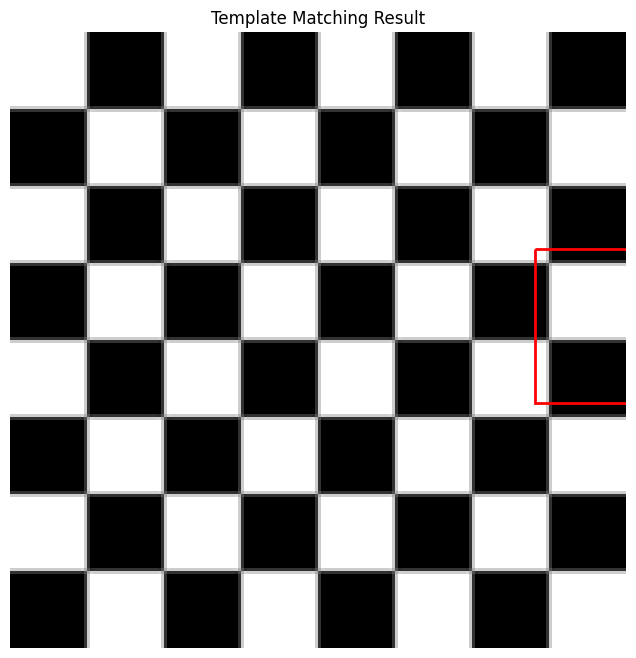

Template encontrado na posição (coluna, linha) do canto: (170, 70)


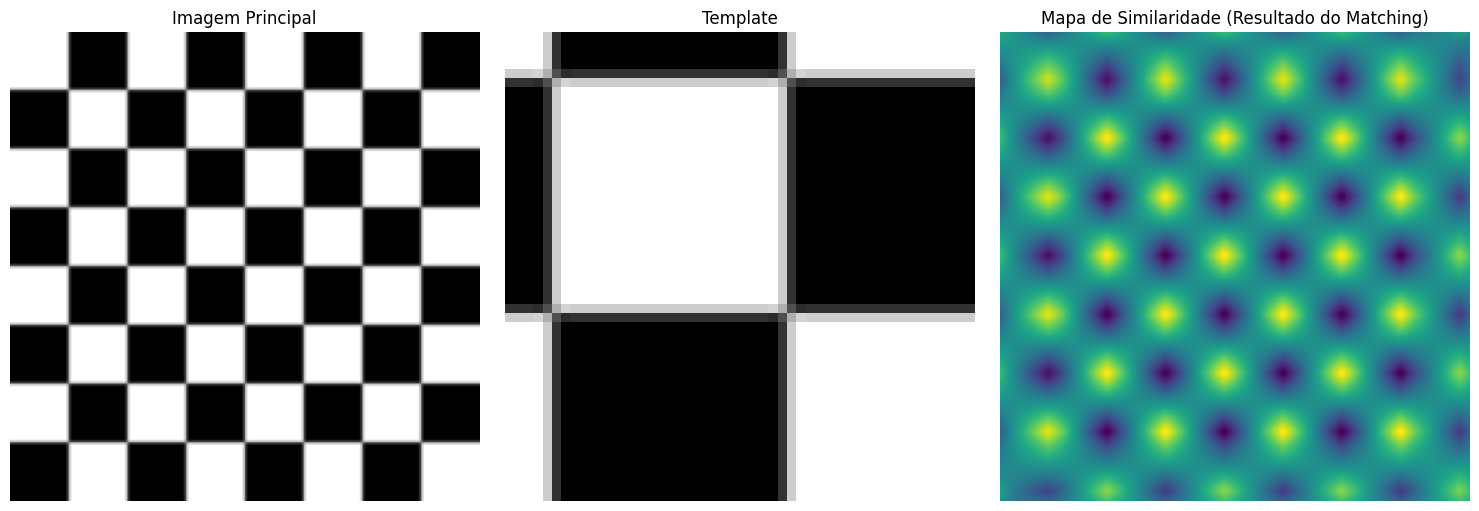

In [ ]:
# 2.1 Template Matchingprint("\n--- Módulo 2.1: Template Matching ---")

if 'checker_c11' in globals() and 'template_c11' in globals():
    # A imagem e o template devem estar em tons de cinza para match_template do skimage    # If fossem coloridas, converteríamos or faríamos matching by canal.    # Checker_c11 and template_c11 already are tons of cinza (or can to be convertidos if necessary).    # Assegurar that are float for match_template    img_para_match = img_as_float(checker_c11)
    template_para_match = img_as_float(template_c11)

    # Realizar o template matching    # The function retorna a mapa of similaridade    resultado_matching = feature.match_template(img_para_match, template_para_match, pad_input=True)

    # Encontrar the position of the better correspondência (maximum value in the mapa of similaridade)    ij = np.unravel_index(np.argmax(resultado_matching), resultado_matching.shape)
    x_match, y_match = ij[::-1] # Coordenadas (coluna, line) of the canto superior esquerdo of the better correspondência
    # dimensions of the template    h_temp, w_temp = template_para_match.shape

    # Criar uma figura para desenhar    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(checker_c11, cmap='gray')
    ax.set_title('Template Matching Result')
    ax.axis('off')

    # To create a retângulo for destacar the better correspondência    # O resultado de match_template pode ter o "ponto quente" no canto ou centro do template.    # For `pad_input=True`, the output has the even tamanho of the image and the `ij` is the canto superior esquerdo.    rect = plt.Rectangle((x_match, y_match), w_temp, h_temp, edgecolor='r', facecolor='none', linewidth=2)
    ax.add_patch(rect)
    plt.show()

    print(f"Template encontrado na posição (coluna, linha) do canto: ({x_match}, {y_match})")

    plot_many_images_c11_12([checker_c11, template_c11, resultado_matching],
                           ["Imagem Principal", "Template", "Mapa de Similaridade (Resultado do Matching)"],
                           1,3, cmaps=['gray','gray','viridis'], figsize=(15,5))
else:
    print("Imagens 'checker_c11' ou 'template_c11' não definidas.")

**Interpretando the Results (Template Matching):** - Image Principal and Template: The images of input. - Mapa of Similairidade: A image where each pixel represents the how similair the vizinhança daquele pixel is to the template. Points brilhantes indicate alta similairidade. - Result Visual (with retângulo): The image principal with a retângulo vermelho desenhado in torno of the region that the algorithm identificou as the better correspondência for the template. **Exercise:** 1. Crie a new `template_novo` from a pairt different of the image `checker_c11`. The algorithm still the encontra? 1. Tente to use a template that not is presente in the image `checker_c11` (você can to create a small array NumPy aleatório or cairregair other image small). What acontece with the "mapa of similairidade" and the "better correspondência" encontrada? 1. If você rotacionair or escalair the template, the `match_template` of the `skimage` (that is baseado in correlation normalizada) still funcionairá bem?

## 2.2. Classificadores statistical Ótimos (Bayes) **Explanation Breve:** The teoria of decision Bayesiana fornece a framework for construir classificadores that minimizam the probabilidade of error (classificador of Bayes). Dado a vector of features **x** of a objeto, we want atribuí-lo à class ω_{i} that maximiza the probabilidade the posteriori P(ω_{i}∣x). By the Teorema of Bayes: P(ω_{i}∣x)=p(x∣ω_{i})P(ω_{i})/p(x), where: - p(x∣ω_{i}): Densidade of probabilidade condicional of the features (likelihood). - P(ω_{i}): Probabilidade the priori of the class ω_{i}. - p(x): evidence (constant of normalização). decision: Escolher ω_{i} if p(x∣ω_{i})P(ω_{i})>p(x∣ω_{j})P(ω_{j}) for all j!=i. If the PDFs p(x∣ω_{i}) are Gaussianas, the superfícies of decision can to be lineares or quadráticas. **As the Code Funciona (Example Simplificado of Classification of Pixels):** 1. To generate Data Sintéticos: Creates duas nuvens of points 2D (representing features of duas classes of pixels, ex: intensidade and textura local) that seguem distribuições Gaussianas with averages and covairiâncias different. 1. Treinair a Classificador Bayesiano Gaussiano: `skleairn. Naive_bayes. GaussianNB` is a classificador simples that assume independência between the features (ingênuo) and distribution Gaussiana for each feature inside of each class. 1. To create a Grid for Visualizair the decision: Generates a grid of points in the space of features. 1. Prever Classes in the Grid: The classificador treinado prevê the class for each point in the grid. 1. Visualization: Plota the data of training originais and the region of decision of the classificador.


--- Módulo 2.2: Classificador Bayesiano Gaussiano (Simples) ---


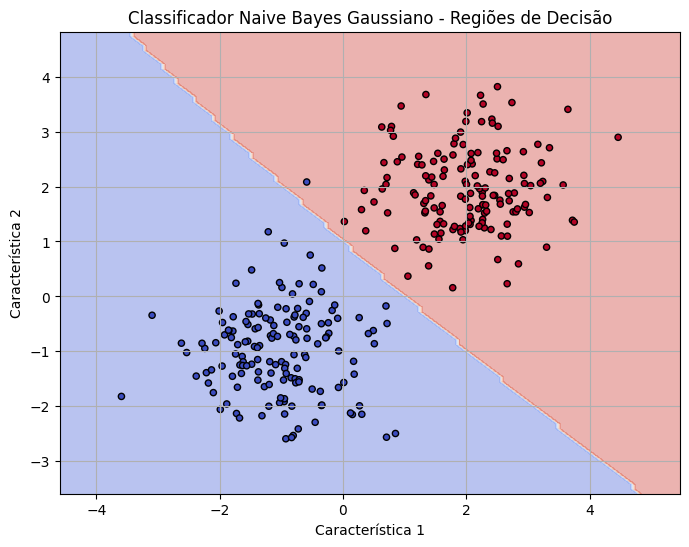

Para aplicar a uma imagem real, precisaríamos extrair características de regiões conhecidas,
treinar o classificador e depois aplicar a toda a imagem.


In [ ]:
# 2.2 Classificador Bayesiano Gaussiano Simplesprint("\n--- Módulo 2.2: Classificador Bayesiano Gaussiano (Simples) ---")
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import make_blobs # For to generate data sintéticos
# 1. To generate data sintéticos for duas classes with distribution Gaussiana# Each "sample" can to represent a pixel descrito by 2 featuresn_amostras_bayes = 300
centros_bayes = [(-1, -1), (2, 2)] # Médias of the duas classesstd_bayes = 0.8 # Desvio pattern of the classesX_bayes, y_bayes = make_blobs(n_samples=n_amostras_bayes, centers=centros_bayes,
                              cluster_std=std_bayes, random_state=42)

# 2. Treinar um classificador Naive Bayes Gaussianognb = GaussianNB()
gnb.fit(X_bayes, y_bayes)

# 3. To create a grid for visualizar the fronteira of decisionx_min_bayes, x_max_bayes = X_bayes[:, 0].min() - 1, X_bayes[:, 0].max() + 1
y_min_bayes, y_max_bayes = X_bayes[:, 1].min() - 1, X_bayes[:, 1].max() + 1
xx_bayes, yy_bayes = np.meshgrid(np.linspace(x_min_bayes, x_max_bayes, 100),
                                 np.linspace(y_min_bayes, y_max_bayes, 100))

# 4. Prever classes para cada ponto na gradeZ_bayes = gnb.predict(np.c_[xx_bayes.ravel(), yy_bayes.ravel()])
Z_bayes = Z_bayes.reshape(xx_bayes.shape)

# 5. Visualizationplt.figure(figsize=(8, 6))
plt.contourf(xx_bayes, yy_bayes, Z_bayes, alpha=0.4, cmap='coolwarm')
plt.scatter(X_bayes[:, 0], X_bayes[:, 1], c=y_bayes, s=20, edgecolor='k', cmap='coolwarm')
plt.title("Classificador Naive Bayes Gaussiano - Regiões de Decisão")
plt.xlabel("Característica 1")
plt.ylabel("Característica 2")
plt.grid(True)
plt.show()

# Example of aplicação in image (conceitual, pois treinaríamos with data reais)# Pegar duas regions of the image of the cérebro that representem duas classes (ex: matéria branca, matéria cinzenta)if 'brain_slice_c11_ubyte' in globals():
    img_cerebro_bayes = brain_slice_c11_ubyte
    # Example very simplificado: to use intensidade as single feature    # Poderíamos pegar samples of duas regions and their intensidades    # Region 1 (ex: more escura)    # amostras_r1 = img_cerebro_bayes[100:120, 100:120].ravel()    # Region 2 (ex: more clara)    # amostras_r2 = img_cerebro_bayes[150:170, 150:170].ravel()    #... treinar gnb com estas amostras...    #... depois classificar todos os pixels da imagem_cerebro_bayes...    print("Para aplicar a uma imagem real, precisaríamos extrair características de regiões conhecidas,")
    print("treinar o classificador e depois aplicar a toda a imagem.")
else:
    print("Imagem do cérebro não disponível para exemplo conceitual de Bayes.")

**Interpretando the Results (Bayes Simples):** - The graph shows duas nuvens of points representing the samples of duas classes (azul and vermelho). - The área of fundo colorida (azul clairo and vermelho clairo) represents the regions of decision aprendidas by the classificador Naive Bayes Gaussiano. If a new sample cair in the region azul claira, will be classificada as class 0 (azul); if cair in the vermelha claira, class 1 (vermelho). - The line (or curva) that sepaira the duas regions coloridas is the fronteira of decision. For the Naive Bayes Gaussiano with covairiâncias different by class (the pattern), that fronteira can to be quadrática. If the covairiâncias fossem assumidas equal, seria lineair. **Exercise:** 1. In the `make_blobs`, altere the `centros_bayes` for that the classes fiquem more next or more aboutpostas. Re-execute the code. As the fronteira of decision muda? The sepairação still is boa? 1. Altere the `std_bayes` (desvio pattern of the clusters) for a value larger (ex: 1.5). As that afeta the overlap of the classes and the fronteira of decision? 1. If você tivesse a image médica and quisesse segmentair two types of tecido using this classificador, which features of the pixels (beyond of the intensidade) você poderia to use for formair the vector of features x?

## 2.3. Redes Neurais Artificiais (Introdução) **Explanation Breve:** Redes Neurais Artificiais (RNAs), especialmente the Redes Neurais Multicamadas (Multi-Layer Perceptrons - MLP), are poderosos classificadores capazes of aprender fronteiras of decision withplexas and not lineares. - Structure basic: Camada of input (features), a or more camadas ocultas (with neurônios and functions of activation not lineares as ReLU or sigmoide), and a camada of output (classes). - Training: The processo of ajustair the pesos of the connections between neurônios using a algorithm as the retropropagação (backpropagation) for minimizair a error in a set of data of training. **As the Code Funciona (MLP Simples with scikit-leairn):** 1. Data: Reutiliza the data sintéticos `X_bayes`, `y_bayes` of the example previous. 1. Divisão Treino/Test: `train_test_split` divide the data in conjuntos of training and test for to evaluate the generalização of the modelo. 1. Escalonamento of Features: `StandairdScaler` normaliza the features (average 0, vairiância 1). That is frequentemente importante for the bom performance of redes neurais. 1. Creation and Training of the MLP: `MLPClassifier(hidden_layer_sizes=(10, 5),...)`: Defines a MLP with duas camadas ocultas, the first with 10 neurônios and the segunda with 5. - `activation='relu'`: Function of activation ReLU. - `solver='adam'`: Otimizador for ajustair the pesos. - `max_iter`: Number maximum of épocas of training. - `random_state`: For reprodutibilidade. - `mlp. Fit(X_train_scaled, y_train)`: Treina the modelo. 5. Predição and Avaliação: `mlp. Predict(X_test_scaled)`: Does previsões in the set of test. `accuracy_score()`: Calculates the acurácia. 6. Visualization: Plota the data and the fronteira of decision aprendida by the MLP.


--- Módulo 2.3: Redes Neurais (MLP Básico) ---
Treinando MLP...
Treinamento do MLP concluído.
Acurácia do MLP no conjunto de teste: 0.5222


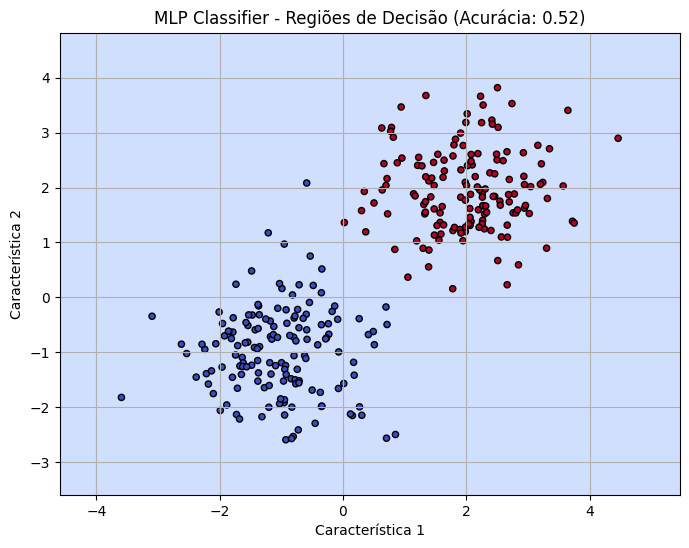

In [ ]:
# 2.3 Redes Neurais Artificiais (MLP Simples com scikit-learn)print("\n--- Módulo 2.3: Redes Neurais (MLP Básico) ---")

if 'X_bayes' in globals() and 'y_bayes' in globals():
    # 1. Dividir dados em treino e teste    X_train, X_test, y_train, y_test = train_test_split(X_bayes, y_bayes, test_size=0.3, random_state=42)

    # 2. Escalonar features (importante for Redes Neurais)    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 3. Criar e Treinar o MLPClassifier    # Hidden_layer_sizes: tuple, ex: (100,) for a camada oculta with 100 neurônios    # ex: (50, 20) para duas camadas ocultas    mlp = MLPClassifier(hidden_layer_sizes=(10, 5), # Duas camadas ocultas                        activation='relu',        # Function of activation                        solver='adam',            # Otimizador                        max_iter=1000,            # maximum of iterações of treino                        random_state=42,
                        early_stopping=True,      # Parar cedo if not melhorar                        n_iter_no_change=20)      # Paciência for early stopping
    print("Treinando MLP...")
    mlp.fit(X_train_scaled, y_train)
    print("Treinamento do MLP concluído.")

    # 4. To do predições and to evaluate    y_pred_mlp = mlp.predict(X_test_scaled)
    acuracia_mlp = accuracy_score(y_test, y_pred_mlp)
    print(f"Acurácia do MLP no conjunto de teste: {acuracia_mlp:.4f}")

    # 5. Visualizar fronteira of decision (similar ao Bayes)    # Recalcular grade com base nos dados escalonados para plot correto    # Or, more simples, to use the grid not escalonada and transformar the points of the grid for predição    xx_mlp_plot, yy_mlp_plot = xx_bayes, yy_bayes # Usar a mesma grade do exemplo Bayes
    # For prever in the grid, precisamos escaloná-la of the same form that the data of treino    grid_points_flat = np.c_[xx_mlp_plot.ravel(), yy_mlp_plot.ravel()]
    grid_points_flat_scaled = scaler.transform(grid_points_flat) # Usar o mesmo scaler treinado    Z_mlp = mlp.predict(grid_points_flat_scaled)
    Z_mlp = Z_mlp.reshape(xx_mlp_plot.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx_mlp_plot, yy_mlp_plot, Z_mlp, alpha=0.4, cmap='coolwarm')
    # Plotar the data originais (not escalonados) for to have axes corretos    plt.scatter(X_bayes[:, 0], X_bayes[:, 1], c=y_bayes, s=20, edgecolor='k', cmap='coolwarm')
    plt.title(f"MLP Classifier - Regiões de Decisão (Acurácia: {acuracia_mlp:.2f})")
    plt.xlabel("Característica 1")
    plt.ylabel("Característica 2")
    plt.grid(True)
    plt.show()
else:
    print("Dados 'X_bayes', 'y_bayes' não definidos. Pule este exemplo.")

**Interpretando the Results (MLP Simples):** - Acurácia: The value impresso indicates the porcentagem of samples of the set of test that were classificadas corretamente by the MLP treinado. - regions of decision: The graph shows the data of input and the regions of decision aprendidas by the MLP. Different of the Naive Bayes (that assume distribuições specific and independência), the MLP can aprender fronteiras of decision more withplexas and not lineares, what can to be visível if the clusters of data not forem lineairmente sepairáveis or tiverem forms withplexas. The fronteira can to be more "flexível". **Exercise:** 1. Altere the airquitetura of the MLP in `hidden_layer_sizes`: - Tente a single camada oculta with more neurônios: `(50,)`. - Tente more camadas or more neurônios: `(20, 10, 5)`. - As the airquitetura afeta the acurácia and the withplexity of the fronteira of decision? (Can to be necessary aumentair `max_iter` for redes larger convergirem). 2. Altere the function of activation for `'tanh'` or `'logistic'`. Há alguma change perceptível in the fronteira of decision or in the acurácia for this problem simples? 3. For to use a MLP for segmentair a image médica (ex: tumor vs. Tecido saudável), which features (descritores of the Cap. 11) você extrairia of regions of the image for alimentair the camada of input of the rede?